In [1]:
%matplotlib notebook
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
sns.set()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cpu


## Setup Tensorboard

In [3]:
#default logdir is "runs"
writer = SummaryWriter('runs/cnn')

## Load data from files

In [4]:
#Path to data
train_path = 'Data/data_train.npz'
test_path = 'Data/data_test.npz'

In [5]:
train_data = np.load(train_path, allow_pickle=True)
test_data = np.load(test_path, allow_pickle=True)

In [6]:
Cluster_train =  train_data['Cluster']
ClusterType_train = train_data['ClusterType']
ClusterE_train = train_data['ClusterE']
ClusterPt_train = train_data['ClusterPt']
ClusterModuleNumber_train = train_data['ClusterModuleNumber']
ClusterX_train = train_data['ClusterX']
ClusterY_train = train_data['ClusterY']
ClusterM02_train = train_data['ClusterM02']
ClusterM20_train = train_data['ClusterM20']
PartE_train = train_data['PartE']
PartPt_train = train_data['PartPt']
PartEta_train = train_data['PartEta']
PartPhi_train = train_data['PartPhi']
PartIsPrimary_train = train_data['PartIsPrimary']
PartPID_train = train_data['PartPID']

In [7]:
Cluster_test =  test_data['Cluster']
ClusterType_test = test_data['ClusterType']
ClusterE_test = test_data['ClusterE']
ClusterPt_test = test_data['ClusterPt']
ClusterModuleNumber_test = test_data['ClusterModuleNumber']
ClusterX_test = test_data['ClusterX']
ClusterY_test = test_data['ClusterY']
ClusterM02_test = test_data['ClusterM02']
ClusterM20_test = test_data['ClusterM20']
PartE_test = test_data['PartE']
PartPt_test = test_data['PartPt']
PartEta_test = test_data['PartEta']
PartPhi_test = test_data['PartPhi']
PartIsPrimary_test = test_data['PartIsPrimary']
PartPID_test = test_data['PartPID']

## Temporary Change in array size

In [8]:
Cluster_train = Cluster_train[:,18:32,18:32]
Cluster_test = Cluster_test[:,18:32,18:32]

In [9]:
Cluster_test.shape

(2848, 14, 14)

## Temporary change for PID into three categories

In [10]:
def change_pid(arr):
    arr[np.nonzero((arr != 111) & (arr != 221))] = 0
    arr[arr == 111] = 1
    arr[arr == 221] = 2

In [11]:
change_pid(PartPID_test)
change_pid(PartPID_train)

## Reshape the arrays into [size, 1] for usage with ptorch

In [12]:
Cluster_train = Cluster_train.reshape((ClusterE_train.size,1,14,14))
ClusterType_train = ClusterType_train.reshape((ClusterType_train.size, 1))
ClusterE_train = ClusterE_train.reshape((ClusterE_train.size, 1))
ClusterPt_train = ClusterPt_train.reshape((ClusterPt_train.size, 1))
ClusterModuleNumber_train = ClusterModuleNumber_train.reshape((ClusterModuleNumber_train.size, 1))
ClusterX_train = ClusterX_train.reshape((ClusterX_train.size, 1))
ClusterY_train = ClusterY_train.reshape((ClusterY_train.size, 1))
ClusterM02_train = ClusterM02_train.reshape((ClusterM02_train.size, 1))
ClusterM20_train = ClusterM20_train.reshape((ClusterM20_train.size, 1))
PartE_train = PartE_train.reshape((PartE_train.size, 1))
PartPt_train = PartPt_train.reshape((PartPt_train.size, 1))
PartEta_train = PartEta_train.reshape((PartEta_train.size, 1))
PartPhi_train = PartPhi_train.reshape((PartPhi_train.size, 1))
PartIsPrimary_train = PartIsPrimary_train.reshape((PartIsPrimary_train.size, 1))
PartPID_train = PartPID_train.reshape((PartPID_train.size, 1))

In [13]:
Cluster_test = Cluster_test.reshape((ClusterE_test.size,1,14,14))
ClusterType_test = ClusterType_test.reshape((ClusterType_test.size, 1))
ClusterE_test = ClusterE_test.reshape((ClusterE_test.size, 1))
ClusterPt_test = ClusterPt_test.reshape((ClusterPt_test.size, 1))
ClusterModuleNumber_test = ClusterModuleNumber_test.reshape((ClusterModuleNumber_test.size, 1))
ClusterX_test = ClusterX_test.reshape((ClusterX_test.size, 1))
ClusterY_test = ClusterY_test.reshape((ClusterY_test.size, 1))
ClusterM02_test = ClusterM02_test.reshape((ClusterM02_test.size, 1))
ClusterM20_test = ClusterM20_test.reshape((ClusterM20_test.size, 1))
PartE_test = PartE_test.reshape((PartE_test.size, 1))
PartPt_test = PartPt_test.reshape((PartPt_test.size, 1))
PartEta_test = PartEta_test.reshape((PartEta_test.size, 1))
PartPhi_test = PartPhi_test.reshape((PartPhi_test.size, 1))
PartIsPrimary_test = PartIsPrimary_test.reshape((PartIsPrimary_test.size, 1))
PartPID_test = PartPID_test.reshape((PartPID_test.size, 1))

## Load it to pytorch `tensor`

In [14]:
Cluster_train = torch.as_tensor(Cluster_train, dtype=torch.float32)
ClusterType_train = torch.as_tensor(ClusterType_train, dtype=torch.uint8)
ClusterE_train = torch.as_tensor(ClusterE_train, dtype=torch.float32)
ClusterPt_train = torch.as_tensor(ClusterPt_train, dtype=torch.float32)
ClusterModuleNumber_train = torch.as_tensor(ClusterModuleNumber_train, dtype=torch.uint8)
ClusterX_train = torch.as_tensor(ClusterX_train, dtype=torch.uint8)
ClusterY_train = torch.as_tensor(ClusterY_train, dtype=torch.uint8)
ClusterM02_train = torch.as_tensor(ClusterM02_train, dtype=torch.float32)
ClusterM20_train = torch.as_tensor(ClusterM20_train, dtype=torch.float32)
PartE_train = torch.as_tensor(PartE_train, dtype=torch.float32)
PartPt_train = torch.as_tensor(PartPt_train, dtype=torch.float32)
PartEta_train = torch.as_tensor(PartEta_train, dtype=torch.float32)
PartPhi_train = torch.as_tensor(PartPhi_train, dtype=torch.float32)
PartIsPrimary_train = torch.as_tensor(PartIsPrimary_train, dtype=torch.bool)
PartPID_train = torch.as_tensor(PartPID_train, dtype=torch.short)

In [15]:
Cluster_test = torch.as_tensor(Cluster_test, dtype=torch.float32)
ClusterType_test = torch.as_tensor(ClusterType_test, dtype=torch.uint8)
ClusterE_test = torch.as_tensor(ClusterE_test, dtype=torch.float32)
ClusterPt_test = torch.as_tensor(ClusterPt_test, dtype=torch.float32)
ClusterModuleNumber_test = torch.as_tensor(ClusterModuleNumber_test, dtype=torch.uint8)
ClusterX_test = torch.as_tensor(ClusterX_test, dtype=torch.uint8)
ClusterY_test = torch.as_tensor(ClusterY_test, dtype=torch.uint8)
ClusterM02_test = torch.as_tensor(ClusterM02_test, dtype=torch.float32)
ClusterM20_test = torch.as_tensor(ClusterM20_test, dtype=torch.float32)
PartE_test = torch.as_tensor(PartE_test, dtype=torch.float32)
PartPt_test = torch.as_tensor(PartPt_test, dtype=torch.float32)
PartEta_test = torch.as_tensor(PartEta_test, dtype=torch.float32)
PartPhi_test = torch.as_tensor(PartPhi_test, dtype=torch.float32)
PartIsPrimary_test = torch.as_tensor(PartIsPrimary_test, dtype=torch.bool)
PartPID_test = torch.as_tensor(PartPID_test, dtype=torch.short)

## Load it to pytorch `DataLoader`

In [16]:
dataset_train = utils.TensorDataset( Cluster_train, ClusterType_train, ClusterE_train, ClusterPt_train
                                    , ClusterModuleNumber_train, ClusterX_train, ClusterY_train
                                    , ClusterM02_train, ClusterM20_train, PartE_train, PartPt_train
                                    , PartEta_train, PartPhi_train, PartIsPrimary_train, PartPID_train )

In [17]:
dataset_test = utils.TensorDataset( Cluster_test, ClusterType_test, ClusterE_test, ClusterPt_test
                                    , ClusterModuleNumber_test, ClusterX_test, ClusterY_test
                                    , ClusterM02_test, ClusterM20_test, PartE_test, PartPt_test
                                    , PartEta_test, PartPhi_test, PartIsPrimary_test, PartPID_test )

In [18]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)

In [19]:
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True)

## Writing Examples to Tensorboard

In [20]:
#Get one batch of data
dataiter = iter(dataloader_train)
data = dataiter.next()

clus, cle, clpt, clmodnum, clx, cly, pid = data[0].float().to(device), data[2].float().to(device), \
            data[3].float().to(device), data[4].float().to(device), data[5].float().to(device), \
            data[6].float().to(device), data[14].float().to(device)

clusprop = torch.cat([cle.to(device), clpt.to(device), clmodnum.to(device), clx.to(device), cly.to(device)], dim=1)

# create grid
img_grid = torchvision.utils.make_grid(clus)

writer.add_image("Cluster_Examples", img_grid)

In [22]:
#Provide a projector in tensorboard
features = clus.view(-1,14*14)
classes = ['bck', 'pi', 'eta']
class_labels = [classes[int(lab.item())] for lab in pid]
writer.add_embedding( features, metadata=class_labels, label_img=clus, tag='cluster')
writer.close()

## Instance Noise

In [21]:
# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = False

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

## Define the network

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(10,10, kernel_size=3,  padding=2)
        self.conv3 = nn.Conv2d(10,10, kernel_size=5, padding=4)
        self.conv4 = nn.Conv2d(10,5, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(5,3, kernel_size=1)
        self.flatten = nn.Flatten()
        self.dense_nn = nn.Sequential(
            nn.Linear(4845, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,3),
            nn.ReLU()
        )
        
    def forward(self, cluster, clusNumXYEPt):
        cluster = F.relu(self.conv1(cluster))
        cluster = F.relu(self.conv2(cluster))
        cluster = F.relu(self.conv3(cluster))
        x = self.flatten(cluster)
        x = torch.cat([x, clusNumXYEPt], dim=1)
        logits = self.dense_nn(x)
        return logits

In [32]:
device = 'cpu'

In [33]:
model = CNN().to(device)

In [25]:
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
  (conv4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(5, 3, kernel_size=(1, 1), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_nn): Sequential(
    (0): Linear(in_features=3245, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=3, bias=True)
    (11): ReLU()
  )
)


## Model Inspection with tensorboard

In [46]:
writer.add_graph(model, [clus, clusprop])
writer.close()

## Set loss function and dataloader

In [26]:
learning_rate = 1e-3

loss_fn = F.cross_entropy

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

## Implement train and test loop
[0:'Cluster', 1:'ClusterType', 2:'ClusterE', 3:'ClusterPt', 4:'ClusterModuleNumber', 5:'ClusterX', 6:'ClusterY', 7:'ClusterM02', 8:'ClusterM20', 9:'PartE', 10:'PartPt', 11:'PartEta', 12:'PartPhi', 13:'PartIsPrimary', 14:'PartPID']

In [41]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        Cl, ClE, ClPt, ClModNum, ClX, ClY, PartPID = data[0].float().to(device), data[2].float().to(device), \
        data[3].float().to(device), data[4].float().to(device), data[5].float().to(device), \
        data[6].float().to(device), data[14].float().to(device)
        
        ClusterProperties = torch.cat([ClE.to(device), ClPt.to(device), ClModNum.to(device), ClX.to(device), ClY.to(device)], dim=1)
        
        if INSTANCE_NOISE:
            Cl = add_instance_noise(Cl)
        
        #prediction and loss
        pred = model(Cl, ClusterProperties)
        loss = loss_fn(pred, PartPID[:,0].long())
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 9:
            loss, current = loss.item(), batch * len(ClE)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        

In [28]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for data in dataloader:
            Cl, ClE, ClPt, ClModNum, ClX, ClY, PartPID = data[0].float().to(device), data[2].float().to(device), \
            data[3].float().to(device), data[4].float().to(device), data[5].float().to(device), \
            data[6].float().to(device), data[14].float().to(device)
            
            ClusterProperties = torch.cat([ClE.to(device), ClPt.to(device), ClModNum.to(device), ClX.to(device), ClY.to(device)], dim=1)
            
            if INSTANCE_NOISE:
                Cl = add_instance_noise(Cl)
            
            pred = model(Cl, ClusterProperties)
            test_loss += loss_fn(pred, PartPID[:,0].long()).item()
            correct += (pred.argmax(1) == PartPID[:,0]).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [29]:
def run_training(epochs, start=0):
    dat=[0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    line1, = ax.plot(dat, label='epoch_loss')
    plt.legend()
    ax.set_xlim([0,epochs])
    fig.canvas.draw()
    for epoch in tqdm(range(start, epochs)):
        print(f"Epoch {epoch+1}\n-------------------------------")
        
        train_loop(dataloader_train, model, loss_fn, optimizer)
        test_loss, _ = test_loop(dataloader_test, model, loss_fn)
        
        if epoch == 0:
            dat = [test_loss]
        else:    
            dat.append(test_loss)
        line1.set_ydata(dat)
        line1.set_xdata(range(len(dat)))
        ax.set_ylim(0, np.max(dat)+1)
        fig.canvas.draw()
        #time.sleep(0.1)
    print("Done!")

<IPython.core.display.Javascript object>


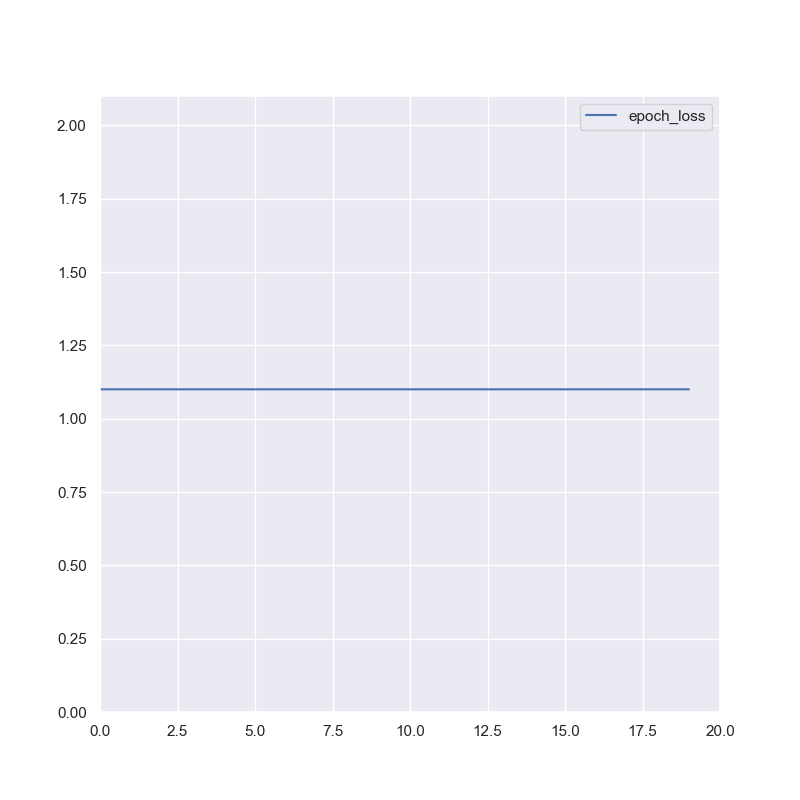

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.100156 [ 1152/11386]
loss: 1.099866 [ 2432/11386]
loss: 1.099897 [ 3712/11386]
loss: 1.099945 [ 4992/11386]
loss: 1.100061 [ 6272/11386]
loss: 1.100085 [ 7552/11386]
loss: 1.099852 [ 8832/11386]
loss: 1.099885 [10112/11386]
Test Error: 
 Accuracy: 11.8%, Avg loss: 1.100011 

Epoch 2
-------------------------------
loss: 1.100235 [ 1152/11386]
loss: 1.099963 [ 2432/11386]
loss: 1.099788 [ 3712/11386]
loss: 1.100295 [ 4992/11386]
loss: 1.099990 [ 6272/11386]
loss: 1.099865 [ 7552/11386]
loss: 1.099829 [ 8832/11386]
loss: 1.100116 [10112/11386]
Test Error: 
 Accuracy: 11.8%, Avg loss: 1.100029 

Epoch 3
-------------------------------
loss: 1.099932 [ 1152/11386]
loss: 1.099779 [ 2432/11386]
loss: 1.099867 [ 3712/11386]
loss: 1.099981 [ 4992/11386]
loss: 1.099885 [ 6272/11386]
loss: 1.099889 [ 7552/11386]
loss: 1.099957 [ 8832/11386]
loss: 1.100280 [10112/11386]
Test Error: 
 Accuracy: 11.8%, Avg loss: 1.099991 

Epoch 4
--------------------

In [42]:
plt.ion()
run_training(20)